# Imports

[](http://)

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# ---------------------------- Configuration ---------------------------- #

img_size = 96
num_classes = 20  # thumb, index, middle, ring, little

# Replace these with actual dataset paths
train_paths = [
    "../input/socofing/SOCOFing/Altered/Altered-Easy",
    "../input/socofing/SOCOFing/Altered/Altered-Medium",
    "../input/socofing/SOCOFing/Altered/Altered-Hard"
]
test_path = "../input/socofing/SOCOFing/Real"

In [3]:
import os
import numpy as np
import cv2

# Assume img_size is defined somewhere before using these functions
# For example: img_size = 96

# ---------------------------- Functions ---------------------------- #

def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    if train:
        gender_code, lr_code, finger_code, _, _ = etc.split('_')
    else:
        gender_code, lr_code, finger_code, _ = etc.split('_')

    # Decode gender
    gender = 'Male' if gender_code == 'M' else 'Female'

    # Decode left/right
    lr = 'Left' if lr_code == 'Left' else 'Right'

    # Decode finger type
    if finger_code == 'thumb':
        finger = 'thumb'
    elif finger_code == 'index':
        finger = 'index'
    elif finger_code == 'middle':
        finger = 'middle'
    elif finger_code == 'ring':
        finger = 'ring'
    elif finger_code == 'little':
        finger = 'little'
    else:
        raise ValueError("Unknown finger type: " + finger_code)

    # Combine into one label
    combined_label = f"{gender}_{lr}_{finger}"

    return np.array([subject_id, combined_label], dtype=object)

def loading_data(paths, train=True):
    data = []
    for path in paths:
        print(f"Loading data from: {path}")
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_resize = cv2.resize(img_array, (img_size, img_size))
                label = extract_label(os.path.join(path, img), train)
                data.append([label[1], img_resize])  # label[1] is combined label
            except Exception as e:
                print(f"Skipping {img}: {e}")
    return data

def loading_test_data(path, train=False):
    data = []
    print(f"Loading test data from: {path}")
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img), train)
            data.append([label[1], img_resize])
        except Exception as e:
            print(f"Skipping {img}: {e}")
    return data


In [30]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---------------------------- Load Data ---------------------------- #
train_data = []
for path in train_paths:   # 20 folders
    train_data.extend(loading_data([path], train=True))

# Convert into arrays
X, y = [], []
for label, feature in train_data:
    X.append(feature)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0
y = np.array(y)

# ---------------- Create Label Mapping ---------------- #
all_labels = sorted(list(set(y.tolist())))
num_classes = len(all_labels)

label_to_index = {label: idx for idx, label in enumerate(all_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

y = np.array([label_to_index[label] for label in y])

# ---------------- Balance Dataset ---------------- #
# Group indices per class
class_indices = {cls: np.where(y == cls)[0] for cls in np.unique(y)}

# Find the minimum class size (so every class has equal samples)
min_count = min(len(idxs) for idxs in class_indices.values())
print("Balancing each class to:", min_count, "images")

balanced_indices = []
for cls, idxs in class_indices.items():
    chosen = np.random.choice(idxs, min_count, replace=False)
    balanced_indices.extend(chosen)

random.shuffle(balanced_indices)

X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# ---------------- Train/Val/Test Split ---------------- #
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1)

# One-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val   = to_categorical(y_val, num_classes)
y_test  = to_categorical(y_test, num_classes)

# ---------------- Dataset Sizes ---------------- #
print("Number of classes:", num_classes)
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Test samples:", X_test.shape[0])


Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Hard
Balancing each class to: 947 images
Number of classes: 20
Training samples: 13258
Validation samples: 2841
Test samples: 2841


In [31]:
import numpy as np
from collections import Counter
import random
from tensorflow.keras.utils import to_categorical

# ---------------------- Convert one-hot back ---------------------- #
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels   = np.argmax(y_val, axis=1)
y_test_labels  = np.argmax(y_test, axis=1)

# Reverse mapping (index → class name)
index_to_label = {idx: label for label, idx in label_to_index.items()}

def print_class_distribution(y_labels, dataset_name):
    counts = Counter(y_labels)
    print(f"\n{dataset_name} Class Distribution:")
    for idx, count in counts.items():
        print(f"{index_to_label[idx]} : {count} images")

# ---------------------- Print before undersampling ---------------------- #
print_class_distribution(y_train_labels, "Training (Before)")
print_class_distribution(y_val_labels,   "Validation (Before)")
print_class_distribution(y_test_labels,  "Test")


Training (Before) Class Distribution:
Male_Left_ring : 663 images
Female_Right_ring : 663 images
Male_Left_thumb : 663 images
Female_Right_little : 663 images
Male_Right_index : 663 images
Female_Left_little : 663 images
Male_Right_middle : 663 images
Female_Left_index : 663 images
Male_Right_ring : 663 images
Female_Right_middle : 663 images
Male_Right_little : 663 images
Male_Left_middle : 663 images
Female_Left_middle : 663 images
Male_Right_thumb : 663 images
Female_Right_thumb : 663 images
Female_Left_ring : 663 images
Female_Right_index : 662 images
Male_Left_little : 662 images
Female_Left_thumb : 663 images
Male_Left_index : 663 images

Validation (Before) Class Distribution:
Male_Left_thumb : 142 images
Female_Right_middle : 142 images
Male_Left_middle : 142 images
Female_Left_little : 142 images
Male_Right_ring : 142 images
Female_Left_index : 142 images
Male_Left_index : 142 images
Female_Right_little : 142 images
Female_Left_ring : 142 images
Male_Right_index : 142 images


In [32]:
print(label_to_index)

{'Female_Left_index': 0, 'Female_Left_little': 1, 'Female_Left_middle': 2, 'Female_Left_ring': 3, 'Female_Left_thumb': 4, 'Female_Right_index': 5, 'Female_Right_little': 6, 'Female_Right_middle': 7, 'Female_Right_ring': 8, 'Female_Right_thumb': 9, 'Male_Left_index': 10, 'Male_Left_little': 11, 'Male_Left_middle': 12, 'Male_Left_ring': 13, 'Male_Left_thumb': 14, 'Male_Right_index': 15, 'Male_Right_little': 16, 'Male_Right_middle': 17, 'Male_Right_ring': 18, 'Male_Right_thumb': 19}


In [33]:
# ---------------------------- Model Definition ---------------------------- #

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 32)        832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)       

In [41]:
# ---------------------------- Callbacks ---------------------------- #

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("finger_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

# ---------------------------- Model Training ---------------------------- #

# ---------------------------- Model Training ---------------------------- #
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=callbacks
)


Train on 13258 samples, validate on 2841 samples
Epoch 1/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 1.0374 - acc: 0.6247 - val_loss: 0.6545 - val_acc: 0.8321
Epoch 2/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.9254 - acc: 0.6648 - val_loss: 0.5672 - val_acc: 0.8339
Epoch 3/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.8809 - acc: 0.6845 - val_loss: 0.5770 - val_acc: 0.8381
Epoch 4/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.8440 - acc: 0.6920 - val_loss: 0.5406 - val_acc: 0.8536
Epoch 5/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.8221 - acc: 0.6994 - val_loss: 0.5271 - val_acc: 0.8490
Epoch 6/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.8111 - acc: 0.7072 - val_loss: 0.5516 - val_acc: 0.8490
Epoch 7/30
13258/13258 [==============================] - 14s 1ms/sample - loss: 0.7711 - acc: 0.7180 - val_loss: 0.4

Final Training Accuracy: 0.8404
Final Validation Accuracy: 0.9109
Final Training Loss: 0.4250
Final Validation Loss: 0.3617
Test Accuracy: 0.9190
Test Loss: 0.3348


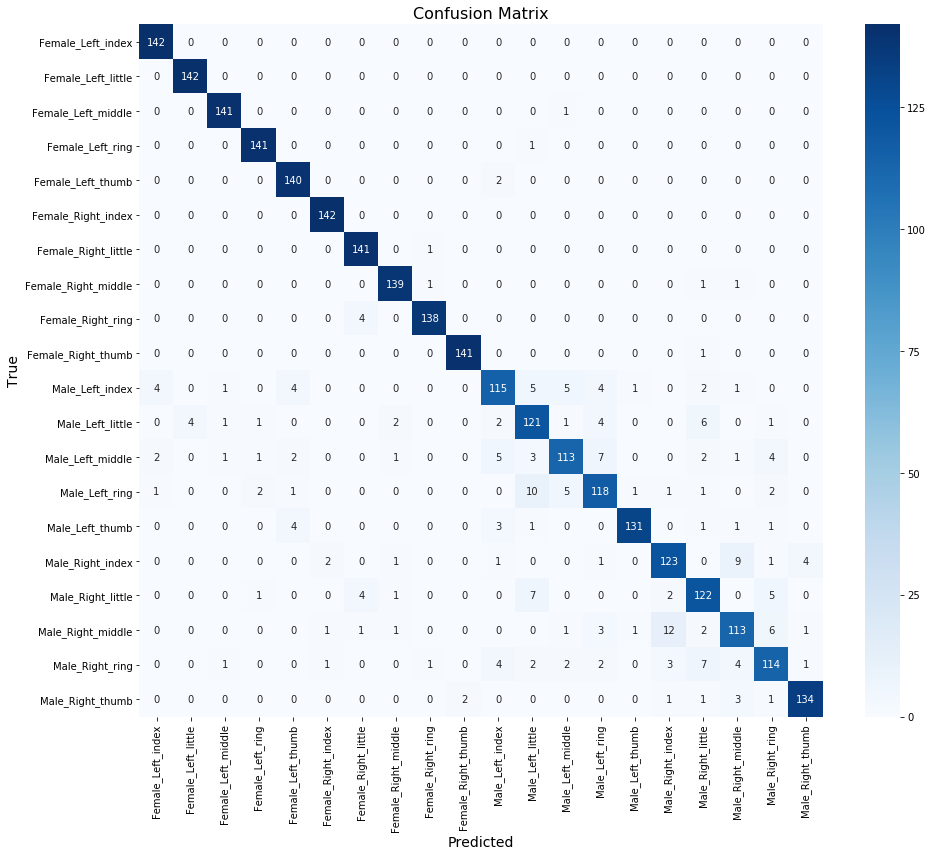


Classification Report:

                     precision    recall  f1-score   support

  Female_Left_index       0.95      1.00      0.98       142
 Female_Left_little       0.97      1.00      0.99       142
 Female_Left_middle       0.97      0.99      0.98       142
   Female_Left_ring       0.97      0.99      0.98       142
  Female_Left_thumb       0.93      0.99      0.96       142
 Female_Right_index       0.97      1.00      0.99       142
Female_Right_little       0.94      0.99      0.97       142
Female_Right_middle       0.96      0.98      0.97       142
  Female_Right_ring       0.98      0.97      0.98       142
 Female_Right_thumb       0.99      0.99      0.99       142
    Male_Left_index       0.87      0.81      0.84       142
   Male_Left_little       0.81      0.85      0.83       143
   Male_Left_middle       0.88      0.80      0.84       142
     Male_Left_ring       0.85      0.83      0.84       142
    Male_Left_thumb       0.98      0.92      0.95       14

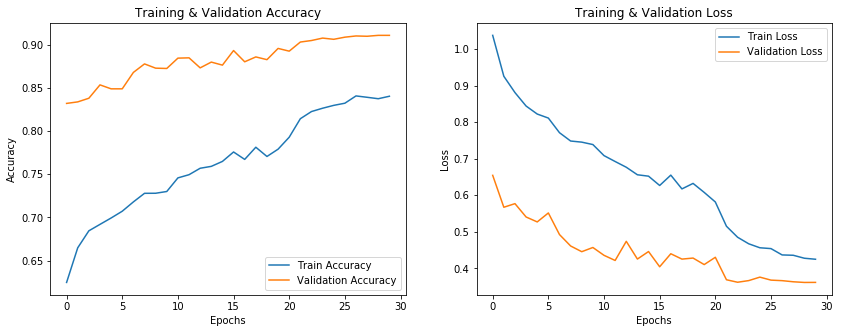

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# ---------------------------- Class Labels ---------------------------- #
class_indices = {
    'Female_Left_index': 0, 'Female_Left_little': 1, 'Female_Left_middle': 2, 'Female_Left_ring': 3, 'Female_Left_thumb': 4,
    'Female_Right_index': 5, 'Female_Right_little': 6, 'Female_Right_middle': 7, 'Female_Right_ring': 8, 'Female_Right_thumb': 9,
    'Male_Left_index': 10, 'Male_Left_little': 11, 'Male_Left_middle': 12, 'Male_Left_ring': 13, 'Male_Left_thumb': 14,
    'Male_Right_index': 15, 'Male_Right_little': 16, 'Male_Right_middle': 17, 'Male_Right_ring': 18, 'Male_Right_thumb': 19
}
labels = list(class_indices.keys())

# ---------------------------- Training & Validation Metrics ---------------------------- #
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# ---------------------------- Test Accuracy ---------------------------- #
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# ---------------------------- Confusion Matrix ---------------------------- #
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)   # predicted classes
y_true = np.argmax(y_test, axis=1)           # true classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=labels))

# ---------------------------- Accuracy & Loss Plots ---------------------------- #
plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.show()


In [44]:
model.save("Finger+gender_model_20.h5")

In [45]:
import numpy as np
import cv2
import json
from tensorflow.keras.models import load_model

# ---------------------------- Configuration ---------------------------- #

img_size = 96
model_path = '/kaggle/working/Finger+gender_model_20.h5'  # Ensure this file is available in the working directory

# Label mapping from your print output
label_to_index = {
    'Female_Left_index': 0, 'Female_Left_little': 1, 'Female_Left_middle': 2, 'Female_Left_ring': 3, 'Female_Left_thumb': 4,
    'Female_Right_index': 5, 'Female_Right_little': 6, 'Female_Right_middle': 7, 'Female_Right_ring': 8, 'Female_Right_thumb': 9,
    'Male_Left_index': 10, 'Male_Left_little': 11, 'Male_Left_middle': 12, 'Male_Left_ring': 13, 'Male_Left_thumb': 14,
    'Male_Right_index': 15, 'Male_Right_little': 16, 'Male_Right_middle': 17, 'Male_Right_ring': 18, 'Male_Right_thumb': 19
}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# ---------------------------- Prediction Function ---------------------------- #

def predict_finger_type(img_path):
    model = load_model(model_path)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or cannot be read: {img_path}")

    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized / 255.0
    img_input = img_normalized.reshape(1, img_size, img_size, 1)

    pred_probs = model.predict(img_input, verbose=0)[0]
    pred_class = np.argmax(pred_probs)
    combined_label = index_to_label[pred_class]

    print(f"Predicted Finger Type: {combined_label}")
    print(f"Confidence: {pred_probs[pred_class]*100:.2f}%")

    return combined_label, pred_probs[pred_class]

# ---------------------------- Example Usage ---------------------------- #

# Replace these paths with the actual paths to your images
test_image_path1 = '/kaggle/input/socofing/SOCOFing/Real/100__M_Left_index_finger.BMP'
test_image_path2 = '/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/103__F_Left_ring_finger_Obl.BMP'
test_image_path3 = '/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP'

# Predict finger type
predict_finger_type(test_image_path1)
predict_finger_type(test_image_path2)
predict_finger_type(test_image_path3)

Predicted Finger Type: Male_Left_middle
Confidence: 66.64%
Predicted Finger Type: Female_Left_ring
Confidence: 99.76%
Predicted Finger Type: Male_Left_middle
Confidence: 66.17%


('Male_Left_middle', 0.6616713)